In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 🔹 Load Dataset
df = pd.read_csv("/kaggle/input/college-basketball-dataset/cbb.csv")

df = df[df["POSTSEASON"].notnull()]  # Only teams that made the tournament

# ✅ Define ordered POSTSEASON categories (including R68)
postseason_order = ['R68', 'R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champ']
label_map = {label: idx for idx, label in enumerate(postseason_order)}
df = df[df["POSTSEASON"].isin(label_map)]
df["POSTSEASON_ENC"] = df["POSTSEASON"].map(label_map)
num_classes = len(postseason_order)

# ➕ Feature Engineering: Derived Metrics
df["NET_EFFICIENCY"] = df["ADJOE"] - df["ADJDE"]
df["EFF_TEMPO"] = df["NET_EFFICIENCY"] * df["ADJ_T"]
df["TOR_RATIO"] = df["TOR"] / (df["TORD"] + 1e-5)
df["REB_RATIO"] = df["ORB"] / (df["DRB"] + 1e-5)
df["3P_vs_2P"] = df["3P_O"] / (df["2P_O"] + 1e-5)

# ✖️ Interaction Terms
df["EFG_x_TOR"] = df["EFG_O"] * df["TOR"]
df["ORB_x_FTR"] = df["ORB"] * df["FTR"]
df["PPS"] = ((3 * df["3P_O"] + 2 * df["2P_O"]) / 8)
df["RPPS"] = df["PPS"] - ((3 * df["3P_D"] + 2 * df["2P_D"]) / 6)

df["RPPP"] = (df["RPPS"] * (df["ADJ_T"] / 40))


df["UPSET_FACTOR"] = df["WAB"] / df["SEED"]

# 🔹 Filter 2025 data
df_2025 = pd.read_csv("/kaggle/input/college-basketball-dataset/cbb25.csv")
df_2025 = df_2025[df_2025["SEED"].notnull()]
df_2025["PPS"] = ((3 * df_2025["3P_O"] + 2 * df_2025["2P_O"]) / 8)
df_2025["RPPS"] = df_2025["PPS"] - ((3 * df_2025["3P_D"] + 2 * df_2025["2P_D"]) / 6)
df_2025["RPPP"] = (df_2025["RPPS"] * (df_2025["ADJ_T"] / 40))
df_2025["UPSET_FACTOR"] = df_2025["WAB"] / df_2025["SEED"]
df_2025["REB_RATIO"] = df_2025["ORB"] / (df_2025["DRB"] + 1e-5)
df_2025["YEAR"] = 2025

# 🧠 Prepare 2025 features (must match original features used in training)


# ✅ Select features
features = [
    "RPPP", "REB_RATIO", "UPSET_FACTOR", "YEAR"
]

X = df[features].values
y = df["POSTSEASON_ENC"].values

X_2025 = df_2025[features].values
scaler = StandardScaler()
X_2025_scaled = scaler.fit_transform(X_2025)

# ⚖️ Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔀 Train/Test Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 🔄 Transform to ordinal format: shape = (num_samples, num_classes - 1)
def make_ordinal_labels(y, num_classes):
    return np.array([[1 if label >= j else 0 for j in range(num_classes - 1)] for label in y])

y_train = make_ordinal_labels(y_train_raw, num_classes)
y_test = make_ordinal_labels(y_test_raw, num_classes)

# 🧠 Ordinal Model
model = keras.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.GaussianNoise(0.1),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),

    layers.Dense(num_classes - 1, activation='sigmoid')  # K - 1 thresholds
])

import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_raw),
    y=y_train_raw
)

# Build a weight mapping
class_weight_dict = dict(enumerate(class_weights))

# Use Series for better indexing
sample_weights_series = pd.Series(y_train_raw).map(class_weight_dict)


2025-04-24 05:08:04.905370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745471285.163941      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745471285.237586      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 05:08:20.435911: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 114: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 122: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Test Accuracy (per-threshold binary): 1.000

Classification Report:
              precision    recall  f1-score   support

         R64       1.00      0.22      0.36         9
         R32       0.62      0.82      0.70        71
         S16       0.29      0.29      0.29        35
          E8       0.40      0.22      0.29        18
          F4       0.00      0.00      0.00         9
         2ND       0.00      0.00      0.00         4
       Champ       0.00      0.00      0.00         2

    accuracy                           0.50       148
   macro avg       0.33      0.22      0.23       148
weighted avg       0.48      0.50      0.46       148



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


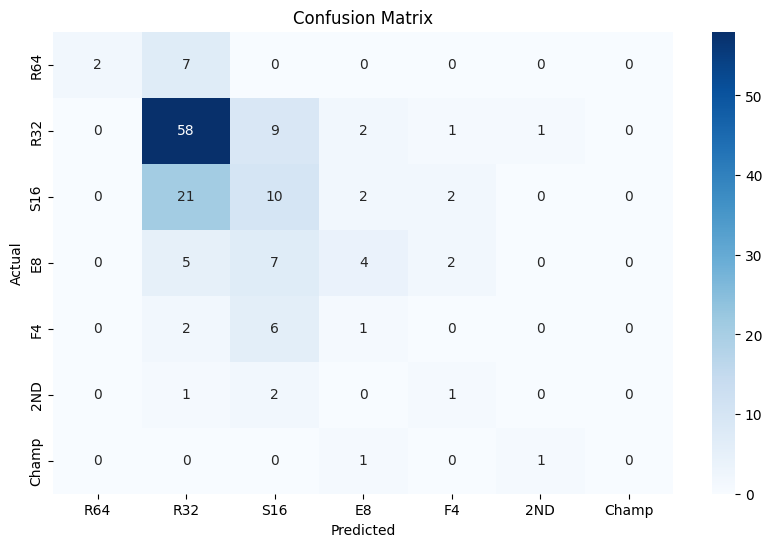

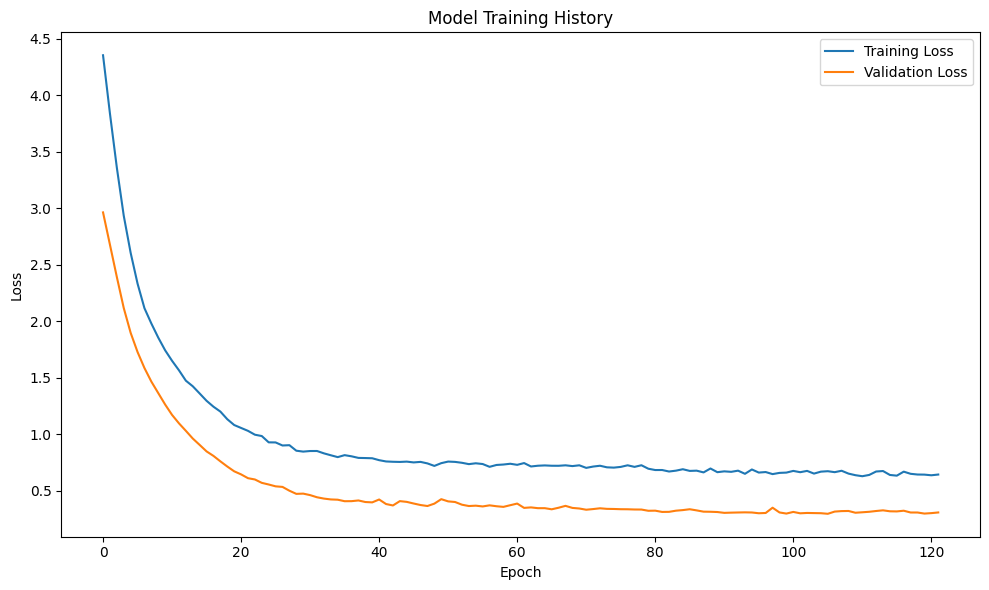


Mean Absolute Error (Ordinal Distance): 0.72


In [2]:
# 🚀 Training

model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

# 🛑 Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=16, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=8, 
    verbose=1, 
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train,
    callbacks=[early_stopping, reduce_lr],
    epochs=1000,
    batch_size=8,
    validation_split=0.2,
    verbose=0,
    class_weight=sample_weights_series
)

# 🔍 Prediction & Evaluation
def from_ordinal_output(output):
    return np.sum(output > 0.5, axis=1)

y_pred_proba = model.predict(X_test)
y_pred_classes = from_ordinal_output(y_pred_proba)
y_test_labels = from_ordinal_output(y_test)

# 📈 Evaluation
print(f"\nTest Accuracy (per-threshold binary): {model.evaluate(X_test, y_test, verbose=0)[1]:.3f}")

present_labels = unique_labels(y_test_labels, y_pred_classes)
present_class_names = [postseason_order[i] for i in present_labels]

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_classes, target_names=present_class_names))

# Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(
    confusion_matrix(y_test_labels, y_pred_classes),
    annot=True,
    fmt='d',
    xticklabels=present_class_names,
    yticklabels=present_class_names,
    cmap='Blues'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Mean Absolute Error (Ordinal Distance)
mae = np.mean(np.abs(y_pred_classes - y_test_labels))
print(f"\nMean Absolute Error (Ordinal Distance): {mae:.2f}")

In [3]:
# 🔍 Predict using trained model
y_2025_proba = model.predict(X_2025_scaled)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [4]:
import numpy as np
import pandas as pd

# df_2025["PREDICTED_STAGE"] = (y_2025_proba)
df_2025["PREDICTED_PROBA"] = list(y_2025_proba)  # store full output
# Get top 64 teams by SEED (lowest = best)
# Filter to top 64 teams by SEED (lowest seed = best)
bracket_teams = df_2025.copy()

# Display relevant columns
bracket_teams = bracket_teams[["Team", "SEED", "PREDICTED_PROBA"]]
bracket_teams = bracket_teams.sort_values("SEED").reset_index(drop=True)

# Manually assigned for this example – update as you see fit
region_map = {
  "Auburn": "South",
  "Alabama St.": "South",
  "Saint Francis": "South",
  "Louisville": "South",
  "Creighton": "South",
  "Michigan": "South",
  "UC San Diego": "South",
  "Texas A&M": "South",
  "Yale": "South",
  "Mississippi": "South",
  "San Diego St.": "South",
  "North Carolina": "South",
  "Iowa St.": "South",
  "Lipscomb": "South",
  "Marquette": "South",
  "New Mexico": "South",
  "Michigan St.": "South",
  "Bryant": "South",
  
  "Duke": "East",
  "American": "East",
  "Mount St. Mary's": "East",
  "Mississippi St.": "East",
  "Baylor": "East",
  "Oregon": "East",
  "Liberty": "East",
  "Arizona": "East",
  "Akron": "East",
  "BYU": "East",
  "VCU": "East",
  "Wisconsin": "East",
  "Montana": "East",
  "Saint Mary's": "East",
  "Vanderbilt": "East",
  "Alabama": "East",
  "Robert Morris": "East",
  
  "Florida": "West",
  "Norfolk St.": "West",
  "Connecticut": "West",
  "Oklahoma": "West",
  "Memphis": "West",
  "Colorado St.": "West",
  "Maryland": "West",
  "Grand Canyon": "West",
  "Missouri": "West",
  "Drake": "West",
  "Texas Tech": "West",
  "UNC Wilmington": "West",
  "Kansas": "West",
  "Arkansas": "West",
  "St. John's": "West",
  "Nebraska Omaha": "West",
  
  "Houston": "Midwest",
  "SIU Edwardsville": "Midwest",
  "Gonzaga": "Midwest",
  "Georgia": "Midwest",
  "Clemson": "Midwest",
  "McNeese St.": "Midwest",
  "Purdue": "Midwest",
  "High Point": "Midwest",
  "Illinois": "Midwest",
  "Texas": "Midwest",
  "Xavier": "Midwest",
  "Kentucky": "Midwest",
  "Troy": "Midwest",
  "UCLA": "Midwest",
  "Utah St.": "Midwest",
  "Tennessee": "Midwest",
  "Wofford": "Midwest"
}

# ----- Assign regions to each team -----
def assign_regions(df, region_map):
    df = df.copy()
    df["REGION"] = df["Team"].map(region_map).fillna("Unknown")
    for i in range(len(df["REGION"])):
        if( df["REGION"][i] == 'Unknown'):
            print(df["Team"][i])

    return df.reset_index(drop=True)
    
def simulate_structured_round(teams_df, round_index, matchups):
    winners = []
    print(f"\n==== ROUND {round_index + 1} ====")
    for i1, i2 in matchups:
        team1 = teams_df.iloc[i1]
        team2 = teams_df.iloc[i2]
        p1 = team1["PREDICTED_PROBA"][round_index] + team1["PREDICTED_PROBA"][round_index + 1]
        p2 = team2["PREDICTED_PROBA"][round_index] + team2["PREDICTED_PROBA"][round_index + 1]
        winner = team1 if p1 > p2 else team2
        print(f"#{team1['SEED']} {team1['Team']} vs #{team2['SEED']} {team2['Team']} --> Winner: {winner['Team']}")
        winners.append(winner)
    return pd.DataFrame(winners).reset_index(drop=True)



# ----- Simulate a single round -----
def simulate_round(teams_df, round_index, mirror=False):
    winners = []
    n = len(teams_df)
    print("\n==== ROUND {} ====".format(round_index + 1))

    if mirror:
        for i in range(n // 2):
            team1 = teams_df.iloc[i]
            team2 = teams_df.iloc[n - 1 - i]
            p1 = team1["PREDICTED_PROBA"][round_index]
            p2 = team2["PREDICTED_PROBA"][round_index]
            winner = team1 if p1 > p2 else team2
            print(f"#{team1['SEED']} {team1['Team']} vs #{team2['SEED']} {team2['Team']} --> Winner: {winner['Team']}")
            winners.append(winner)
    else:
        for i in range(0, n, 2):
            team1 = teams_df.iloc[i]
            team2 = teams_df.iloc[i + 1]
            p1 = team1["PREDICTED_PROBA"][round_index]
            p2 = team2["PREDICTED_PROBA"][round_index]
            winner = team1 if p1 > p2 else team2
            print(f"#{team1['SEED']} {team1['Team']} vs #{team2['SEED']} {team2['Team']} --> Winner: {winner['Team']}")
            winners.append(winner)

    return pd.DataFrame(winners).reset_index(drop=True)


def findteamindex(df, name):
    match = df[df["Team"] == name]
    if not match.empty:
        return match.index[0]
    else:
        raise ValueError(f"Team '{name}' not found in DataFrame.")

# ----- Simulate the full tournament per region and then Final Four -----
def simulate_full_tournament(df, region_map):
    df = assign_regions(df, region_map)
    all_rounds = {}

    # First Four

    print("\n#### First Four ####")
    print("Disclaimer FIRST FOUR MUST BE HARDCODED")

    #Matchup 1 (11)
    San_Diego_State_ID = findteamindex(df, 'San Diego St.')
    North_Carolina_ID = findteamindex(df, 'North Carolina')

    if(df['PREDICTED_PROBA'][San_Diego_State_ID].sum() > df['PREDICTED_PROBA'][North_Carolina_ID].sum()):
        df = df.drop(North_Carolina_ID).reset_index(drop=True)
    else:
        df = df.drop(San_Diego_State_ID).reset_index(drop=True)

    #Matchup 2 (16)
    Alabama_St_ID = findteamindex(df, 'Alabama St.')
    St_Francis_PA_ID = findteamindex(df, 'Saint Francis')
    
    if(df['PREDICTED_PROBA'][Alabama_St_ID].sum() > df['PREDICTED_PROBA'][St_Francis_PA_ID].sum()):
        df = df.drop(St_Francis_PA_ID).reset_index(drop=True)
    else:
        df = df.drop(Alabama_St_ID).reset_index(drop=True)


    #Matchup 3 (16)
    American_ID = findteamindex(df, 'American')
    Mount_ST_Marys_ID = findteamindex(df, "Mount St. Mary's")
    
    if(df['PREDICTED_PROBA'][American_ID].sum() > df['PREDICTED_PROBA'][Mount_ST_Marys_ID].sum()):
        df = df.drop(Mount_ST_Marys_ID).reset_index(drop=True)
    else:
        df = df.drop(American_ID).reset_index(drop=True)


    #Matchup 4 (11)
    Texas_ID = findteamindex(df, 'Texas')
    Xavier_ID = findteamindex(df, 'Xavier')
    
    if(df['PREDICTED_PROBA'][Texas_ID].sum() > df['PREDICTED_PROBA'][Xavier_ID].sum()):
        df = df.drop(Xavier_ID).reset_index(drop=True)
    else:
        df = df.drop(Texas_ID).reset_index(drop=True)
        
    region_matchups = {
        "South": [(0, 15), (7, 8), (4, 11), (3, 12), (5, 10), (2, 13), (6, 9), (1, 14)],
        "East":  [(0, 15), (7, 8), (4, 11), (3, 12), (5, 10), (2, 13), (6, 9), (1, 14)],
        "West":  [(0, 15), (7, 8), (4, 11), (3, 12), (5, 10), (2, 13), (6, 9), (1, 14)],
        "Midwest": [(0, 15), (7, 8), (4, 11), (3, 12), (5, 10), (2, 13), (6, 9), (1, 14)]
    }

    round_32_matchups = [(0, 1), (2, 3), (4, 5), (6, 7)]
    sweet_16_matchups = [(0, 1), (2, 3)]
    elite_8_matchups = [(0, 1)]


    # Simulate each region
    final_four = []
    for region in ["East", "West", "South", "Midwest"]:
        print(f"\n#### Simulating {region} Region ####")
        region_df = df[df["REGION"] == region].sort_values("SEED").iloc[:16].reset_index(drop=True)
        rounds = [region_df]
        round_index = 0

        # Round of 64
        r1 = simulate_structured_round(rounds[-1], round_index, region_matchups[region])
        rounds.append(r1)
        round_index += 1

        # Round of 32
        r2 = simulate_structured_round(rounds[-1], round_index, round_32_matchups)
        rounds.append(r2)
        round_index += 1

        # Sweet 16
        r3 = simulate_structured_round(rounds[-1], round_index, sweet_16_matchups)
        rounds.append(r3)
        round_index += 1

        # Elite 8
        r4 = simulate_structured_round(rounds[-1], round_index, elite_8_matchups)
        rounds.append(r4)
        round_index += 1

        all_rounds[region] = rounds
        final_four.append(rounds[-1].iloc[0])

    # Final Four to Champion
    print("\n#### Final Four ####")
    final_four_ordered = pd.DataFrame([
        final_four[2],  # South
        final_four[1],  # East
        final_four[0],  # West
        final_four[3],  # Midwest
    ]).reset_index(drop=True)
    
    semi_final = simulate_round(final_four_ordered, round_index, mirror=False)

    print("\n#### Championship Game ####")
    champion = simulate_round(semi_final, round_index + 1, mirror=False)

    return all_rounds, semi_final, champion

# Example usage:
# Ensure bracket_teams exists with columns ["Team", "SEED", "PREDICTED_PROBA"]
# region_map must be complete for all top 64 teams
all_rounds, final_four, champion = simulate_full_tournament(bracket_teams, region_map)

# Display champion
print("\n🏆 National Champion:")
print(champion[["Team", "SEED", "REGION"]])


#### First Four ####
Disclaimer FIRST FOUR MUST BE HARDCODED

#### Simulating East Region ####

==== ROUND 1 ====
#1.0 Duke vs #16.0 Mount St. Mary's --> Winner: Duke
#8.0 Mississippi St. vs #9.0 Baylor --> Winner: Baylor
#5.0 Oregon vs #12.0 Liberty --> Winner: Oregon
#4.0 Arizona vs #13.0 Akron --> Winner: Arizona
#6.0 BYU vs #11.0 VCU --> Winner: BYU
#3.0 Wisconsin vs #14.0 Montana --> Winner: Wisconsin
#7.0 Saint Mary's vs #10.0 Vanderbilt --> Winner: Saint Mary's
#2.0 Alabama vs #15.0 Robert Morris --> Winner: Alabama

==== ROUND 2 ====
#1.0 Duke vs #9.0 Baylor --> Winner: Duke
#5.0 Oregon vs #4.0 Arizona --> Winner: Arizona
#6.0 BYU vs #3.0 Wisconsin --> Winner: Wisconsin
#7.0 Saint Mary's vs #2.0 Alabama --> Winner: Alabama

==== ROUND 3 ====
#1.0 Duke vs #4.0 Arizona --> Winner: Duke
#3.0 Wisconsin vs #2.0 Alabama --> Winner: Alabama

==== ROUND 4 ====
#1.0 Duke vs #2.0 Alabama --> Winner: Duke

#### Simulating West Region ####

==== ROUND 1 ====
#1.0 Florida vs #16.0 Norfolk 